This notebook reads the dictionary of training images and gdf of metadata created by getSentinel.ipynb. The data are then used to fine-tune the VGG16 model that has already been pre-trained on ImageNet data.

In [ ]:
try:
  import livelossplot
except ModuleNotFoundError:
  !pip install livelossplot

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

In [3]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

with open(f'{data_path}sentinel_images.pkl', 'rb') as f:
    image_dict = pickle.load(f)

metadata = pd.read_pickle(f'{data_path}metadata_gdf.pkl')

In [6]:

images = []
labels = []
metadata_list = []

for idx, image in image_dict.items():
  if metadata.loc[idx, 'Farm type'] in ["Poultry", "Broiler", "Layer",\
                                        "Unknown CAFO"]:
    labels.append("CAFO")
    images.append(image)
  elif metadata.loc[idx, 'Farm type'] == "Pig": #EXCLUDE PIG FARMS
    continue
  elif metadata.loc[idx, 'Farm type'] == "Non-farm":
    labels.append(metadata.loc[idx, 'Farm type'])
    images.append(image)
  else:
    print(f"Unknown farm type, {metadata.loc[idx, 'Farm type']}")
  metadata_list.append(metadata.loc[idx].to_dict())

# Labels --> categorical --> one hot
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels, num_classes=len(set(labels)))

class_mapping = dict(zip(encoded_labels, labels))
print("Class mapping:", class_mapping)
n_classes = len(class_mapping)

# Combine images, labels, and metadata into a DataFrame for shuffling
data = list(zip(images, one_hot_labels, metadata_list))
df = pd.DataFrame(data, columns=['image', 'label', 'metadata'])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Class mapping: {0: 'CAFO', 1: 'Non-farm'}


In [7]:
# Create training, validation, and test datasets

# Split into (training+validation) and test sets (10% for testing)
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Split training + validation into training and validation sets (~20% for val)
train_df, val_df = train_test_split(train_val_df, test_size=0.22,\
                                    random_state=42)

# Extract the split data
X_train = np.array(train_df['image'].tolist())
y_train = np.array(train_df['label'].tolist())

X_val = np.array(val_df['image'].tolist())
y_val = np.array(val_df['label'].tolist())

X_test = np.array(test_df['image'].tolist())
y_test = np.array(test_df['label'].tolist())

# The index of each item in X_train etc. should correspond to the index in
# the appropriate dataframe
metadata_train = pd.json_normalize(train_df['metadata'])
metadata_val = pd.json_normalize(val_df['metadata'])
metadata_test = pd.json_normalize(test_df['metadata'])

# Print the number of training, validation, and test images
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Keep copies of original data as the arrays can get changed by the data
# generators
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

Training set: 2737 images
Validation set: 773 images
Test set: 390 images


In [8]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [9]:
# Create the model so as to fine-tune only the top 2 (non-convolutional) layers
# This is essentially extracting features and re-learning how to classify based on them

input_shape=X_train.shape[1:]
optimizer=Adam(learning_rate=0.001)
weights_file = None#'/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'

# Load pretrained layers, excluding fully-connected layers
base_model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Freeze pretrained layers
base_model.trainable = False

# Create new fully-connected layers for classification
top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Combine the base (convolutional) and top (fully-connected) layers
model = Model(inputs=base_model.input, outputs=output_layer)

# If we have already done this step, can load saved weights from file
if weights_file is not None:
  print(f'Loading model from {weights_file}')
  model.load_weights(weights_file)

# Compile the model for training.
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Define early stopping + other callbacks. See
# machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0,
                  patience=6,
                  verbose=2
                  )

mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

pl = PlotLossesCallback()

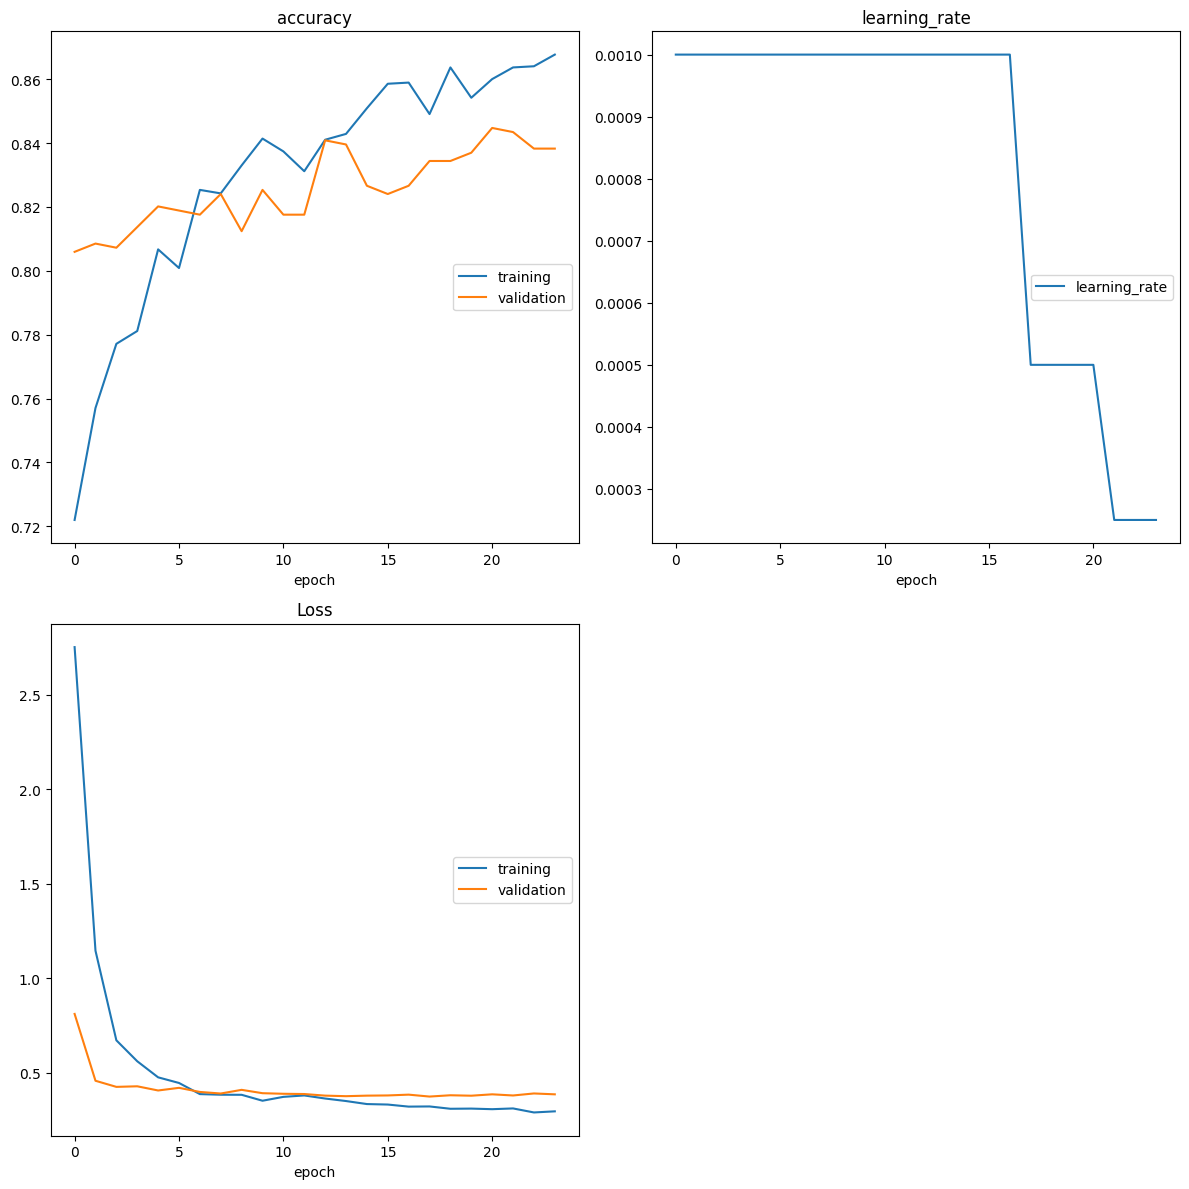

accuracy
	training         	 (min:    0.722, max:    0.868, cur:    0.868)
	validation       	 (min:    0.806, max:    0.845, cur:    0.838)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.289, max:    2.752, cur:    0.295)
	validation       	 (min:    0.373, max:    0.811, cur:    0.385)
86/86 - 9s - 108ms/step - accuracy: 0.8677 - loss: 0.2953 - val_accuracy: 0.8383 - val_loss: 0.3853 - learning_rate: 2.5000e-04
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 18.


In [11]:
# Fit the model, if we haven't reloaded a previously-fitted one

if weights_file is None:

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=2
                    )

In [12]:
# Use the model to make predictions for the test data. As
# EarlyStopping.restore_best_weights=True, this should be the best model,
# not just the final epoch's one

results = utils.get_predictions(model, X_test, y_test, metadata_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


In [13]:
# Generate sklearn classification report
print('\n', classification_report(results["Label"].to_list(), results['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.85      0.92      0.88       262
           1       0.80      0.67      0.73       128

    accuracy                           0.84       390
   macro avg       0.82      0.79      0.81       390
weighted avg       0.83      0.84      0.83       390



In [14]:
# Show some of the correctly- and incorrectly-classified images. Use the
# "ascending" kw to say whether the images should be arranged in order
# of ascending probability (True/False)

utils.plot_classified_images(X_test, results, class_mapping, ascending=True)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# Fine-tune the model

# Set the top few convolutional layers to be trainable
#  --- Do blocks not layers?
for layer in base_model.layers[-4:]:
    layer.trainable = True
    print(f"Layer {layer.name} is trainable")

# Compile the model with a lower learning rate
# Model compiling does not change weights; see
# stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-
# weights-and-biases-in-keras-tensorflow
optimizer=Adam(learning_rate=0.001*0.2)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Update parameters for Reduce LR and EarlyStopping to reduce overfitting
lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0.03,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.03,
                  patience=6,
                  verbose=2
                  )

# Specify a new filename for best model
mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step2.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

Layer block5_conv1 is trainable
Layer block5_conv2 is trainable
Layer block5_conv3 is trainable
Layer block5_pool is trainable


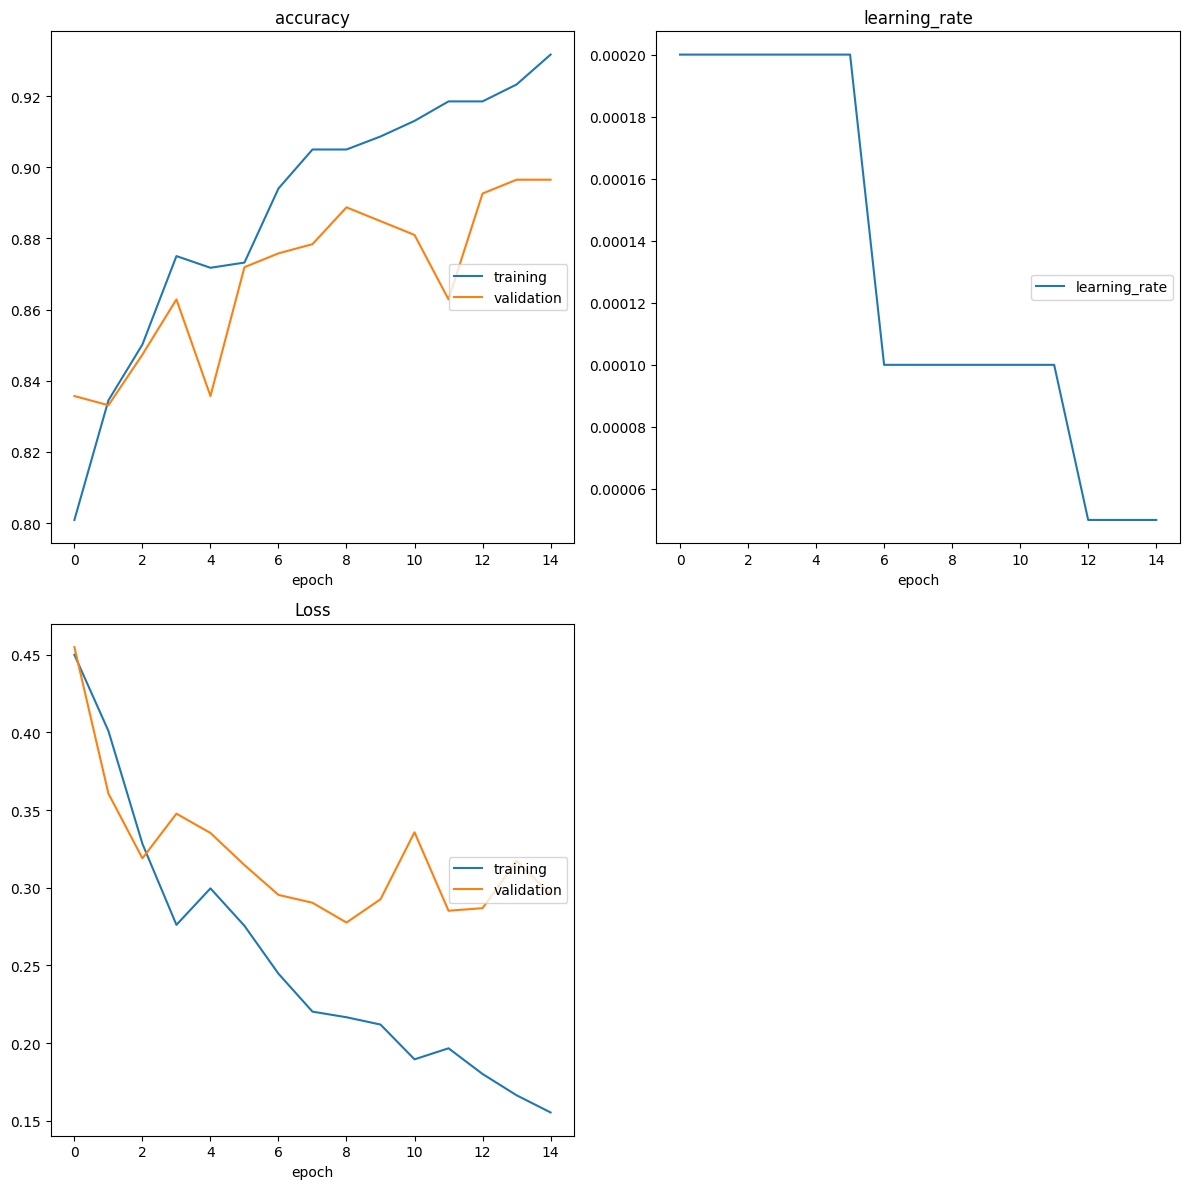

accuracy
	training         	 (min:    0.801, max:    0.932, cur:    0.932)
	validation       	 (min:    0.833, max:    0.897, cur:    0.897)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.155, max:    0.450, cur:    0.155)
	validation       	 (min:    0.278, max:    0.455, cur:    0.296)
86/86 - 7s - 76ms/step - accuracy: 0.9317 - loss: 0.1553 - val_accuracy: 0.8965 - val_loss: 0.2958 - learning_rate: 5.0000e-05
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 9.


In [16]:

weights_file = None#'/content/drive/MyDrive/CAFO_models/VGG16_step2.keras'

if weights_file is not None:
  # Skip fine-tuning and proceed to examine results from existing fine-tuned
  # model
  print(f'Loading weights from {weights_file}')
  model.load_weights(weights_file) #load weights or whole model?

else:

  # Uncomment if this fine-tuning step is interrupted and restarted
  # Otherwise I'm not sure where fitting will start from
  #weights_file = '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'
  #model.load_weights(weights_file)

  # Fit the model
  ft_history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=70, #base epochs + fine-tuning ones?
                    callbacks=[lr, mc, es, pl],
                    verbose=2
                    )

In [17]:

results_ft = utils.get_predictions(model, X_test, y_test, metadata_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [18]:
print('\n', classification_report(results_ft["Label"].to_list(), results_ft['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.91      0.90      0.91       262
           1       0.81      0.81      0.81       128

    accuracy                           0.87       390
   macro avg       0.86      0.86      0.86       390
weighted avg       0.87      0.87      0.87       390



In [19]:
utils.plot_classified_images(X_test, results_ft, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
utils.plot_classified_images(X_test, results_ft, class_mapping, ascending=True)

Output hidden; open in https://colab.research.google.com to view.

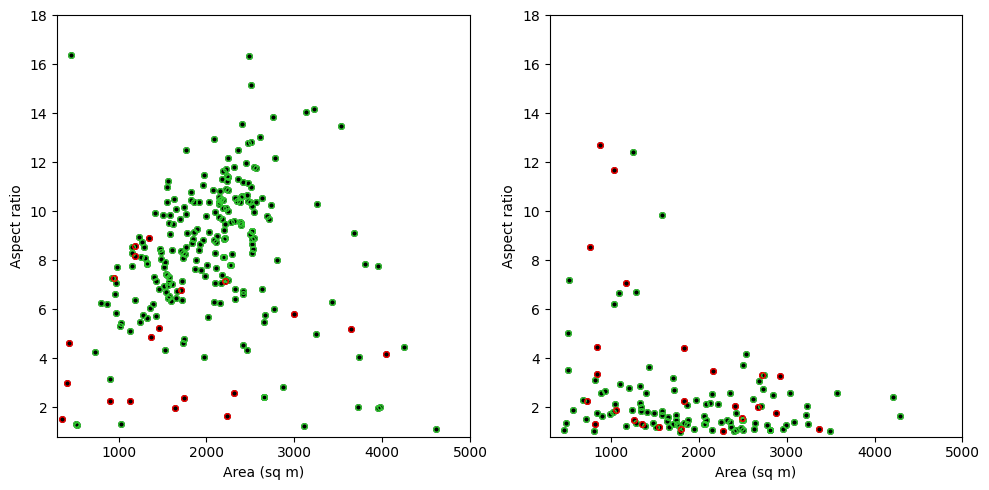

In [20]:
# Visualize the correctly- and incorrectly-classified images on area-aspect
# ratio plots. This is currently set up for just two classes. It might be
# useful to color-code by probability as well, not just right/wrong class. And
# histograms might be (more) useful as well.

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

def add_points(ax, bldgs, correct, incorrect):
  ax.plot(bldgs["Area (sq m)"], bldgs["Aspect ratio"], 'ko', ms=4)
  ax.plot(correct["Area (sq m)"], correct["Aspect ratio"], marker='o',\
          ls='',  ms=4, mec='limegreen', mfc="none")
  ax.plot(incorrect["Area (sq m)"], incorrect["Aspect ratio"], marker='o',\
          ls='',  ms=4, mec='red', mfc="none")
  ax.set_xlim(300, 5000)
  ax.set_ylim(0.8, 18)
  ax.set_xlabel("Area (sq m)")
  ax.set_ylabel("Aspect ratio")

cafos = results_ft[results_ft['Farm type'] != "Non-farm"]
correct = cafos[(cafos['Model Class'] == cafos['Label'])]
incorrect = cafos[(cafos['Model Class'] != cafos['Label'])]
add_points(ax0, cafos, correct, incorrect)

nafos = results_ft[results_ft['Farm type'] == "Non-farm"]
correct = nafos[(nafos['Model Class'] == nafos['Label'])]
incorrect = nafos[(nafos['Model Class'] != nafos['Label'])]
add_points(ax1, nafos, correct, incorrect)

plt.tight_layout()